## Recommender engine for e-commerce 

Problem: create a recommender engine to suggest products to the users visiting an e-commerce site

(Some) comments:

* The dataset consists of a collection of events (namely, 'view', 'addtocart' and 'transaction') describing the actions that visitors to the site carry out with the items offered. It is expected that visitors that buy items with the action 'transaction' have added such items to their cart beforehand 'addtocart' (they may or may have not visited them though).
* The dataset does not contain any information about explicit feedback. Potentially one could consider the price of items and/or number of items bought within a period as a way for implicit feedback. There is also some information about pricing in the dataset but it is not clear how that is linked to the purchases, i.e., the events of the visitors to the site. For simplicity, a binary implicit feedback seems a good approach.
* There is an obvious issue with visitors who do not actually buy anything, but this is more a matter of the function that is considered to create the implicit feedback. For example, one could convert the three types of events to weights and use that information in the following fashion: f(event)_visitor = sum_all(event_visitor*event_type_weight)

(Some) solutions:
* A naive recommender has been built to show a simple but perhaps not so effective solution. Such recommender just connects items that were bought together among all customers, hence it is not that personalised on an individual level but could be useful if considering rules and weights for the events for users for which there is no prior collected information in the site.
* Another recommender based in matrix factorization, and by means of a library, has also been built, but considering only the items that are bought by the visitors. As the information available about feedback on the purchases is implicit, such solution seems appropiate. But this solution is not performing that well due to the nature of building a matrix in a single machine, and so it is not that scalable without a rework on some framework that allows for a distributed computation. One could use more advanced solutions like neuronal networks, e.g., NeuCF.
* There is an interesting catch with the data as the events form some sort of session that could be tracked and modeled for a more accurate computation. GRU4Rec seems to be a structure based on RNNs that accounts for the sequential information that the dataset entitles towards collaborative filtering and the memory that would be needed to remember the different sequences of events to figure out the patterns that lead to a purchase, for example. 

In [1]:
import bz2
from datetime import datetime
import logging
import os
import platform
import pytz
import time
import tqdm
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.sparse as sparse
import seaborn as sns

os.environ["MODIN_ENGINE"] = "ray"  # Modin will be using the Ray engine
# import pandas as pd
import modin.pandas as pd

import implicit
# import lightfm
import tensorflow as tf

In [2]:
python_version = platform.python_version()
tensorflow_version = tf.__version__

if python_version < '3.7':
    print("This notebook requires Python 3.7+ to run. You are running Python {}".format(python_version))
    print("Continue using at your own risk")
else:
    print("Running Python {}".format(python_version))

if tensorflow_version < '2.':
    print("This notebook requires TensorFlow 2+ to run. You are computing with TensorFlow {}".format(tensorflow_version))
    print("Results are not guaranteed to be correct. Continue using at your own risk")
else:
    print("Computing with TensorFlow {}".format(tensorflow_version))

Running Python 3.7.7
Computing with TensorFlow 2.2.0


In [3]:
%matplotlib inline
random_seed = 12345
tf.random.set_seed(random_seed)
sns.set(style="darkgrid")

In [4]:
# Some common variables
# Note: if you move this noteboook to some other path, you will have to adjust the DATA_DIR variable
DATA_DIR = os.path.join(os.getcwd(), 'data')

EVENTS_FILENAME = 'events.csv'
EVENTS_FILE_OPTIONS = {'visitorid': 'string',
                       'itemid': 'string',
                       'event': 'string',
                       'transactionid': 'string'}
CATEGORIES_FILENAME = 'category_tree.csv'
CATEGORIES_FILE_OPTIONS = {'categoryid': 'string',
                           'parentid': 'string'}
ITEMS_PROPERTIES_FILENAME = ['item_properties_part1.csv',
                             'item_properties_part2.csv']
ITEMS_PROPERTIES_FILE_OPTIONS = {'itemid': 'string',
                                 'property': 'string'}

PREDICTION_USERS_FILENAME = 'predictions.csv'
PREDICTION_FILE_OPTIONS = {'visitorid': 'string'}

In [5]:
# Some helper functions
def is_url(uri):
    return urlparse(uri).scheme in ('http', 'https',)

def timestamp_to_date(posix_timestamp, timezone='UTC'):
    """
    Converts a POSIX timestamp to its date type equivalent
    """
    utc_timestamp = datetime.utcfromtimestamp(int(posix_timestamp)).replace(tzinfo=pytz.utc)
    
    # convert it to tz
    if timezone:
        timezone_settings = pytz.timezone(timezone)
        timestamp = utc_timestamp.astimezone(timezone_settings)

    date = timestamp.date()

    return date

def timestamp_to_hour(timestamp, timezone='UTC'):
    """
    Extracts the hour of a UTC datetime object, optionally considering a timezone
    """
    timestamp_timezone = pytz.timezone(timezone).localize(timestamp)
    
    return timestamp_timezone.hour

def str_to_date(date_string, format='%Y-%m-%d'):
    """
    Converts a date string to its date type equivalent
    """
    return datetime.strptime(date_string, format).date()

def remap_list(source, init=0):
    """
    Maps an input list of ids to a sequential list of integers.
    Returns the mapping in either 'direction' for convenience
    """
    
    # Remove potential duplicates
    source = list(dict.fromkeys(source))
    
    source_index = {}
    index_source = {}
    count = init
    
    for l in source:
        source_index[l] = count
        index_source[count] = l
        count += 1

    return source_index, index_source

def load_file(filenames, options=None, bzip2=True):
    """
    Loads the data contained in one or more files and returns it as a Pandas variable
    """
    def read_csv_as_pd(csv_path, options=None):
        if options:
            return pd.read_csv(csv_path, dtype=options)
        else:
            return pd.read_csv(csv_path)
    
    def read_bz2_as_pd(filepath, options=None):
        with bz2.open(filepath, "rt") as f:
            data = read_csv_as_pd(f, options)
            
        return data
    
    def read_gz_as_pd(filepath, options=None):
        data = None
        return data
    
    if type(filenames) is not list:
        filenames = [filenames]
    
    filenames = [filename if is_url(filename) else os.path.join(DATA_DIR, filename) for filename in filenames]
    
    if bzip2:
        filenames = [filename + '.bz2' if bzip2 else filename for filename in filenames]
        df_files_array = (read_bz2_as_pd(filename, options) for filename in filenames)
    else:
        df_files_array = (read_csv_as_pd(filename, options) for filename in filenames)

    data = pd.concat(df_files_array, ignore_index=True)
    
    return data

def save_recommendations(recommendations,
                         filename,
                         user_col='visitorid',
                         item_col_prefix='item_',
                         n=100):

    col_names = [item_col_prefix + str(x) for x in range(n)]

    data = pd.DataFrame.from_dict(recommendations, orient='index', columns=col_names)
    data.index.names = [user_col]
    data.reset_index(inplace=True)

    data.to_csv(filename, index=False)

In [6]:
# Load users to eventually predict on
raw_prediction_users = load_file(PREDICTION_USERS_FILENAME, PREDICTION_FILE_OPTIONS, bzip2=False)

In [7]:
raw_prediction_users.head()

,visitorid
0,593408
1,71998
2,1403739
3,693797
4,1244757


In [8]:
raw_prediction_users.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 174956 entries, 0 to 174955
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   visitorid  174956 non-null  string
dtypes: string(1)
memory usage: 1.3 MB


To request implementation, send an email to feature_requests@modin.org.


In [9]:
# Load events
raw_events = load_file(EVENTS_FILENAME, EVENTS_FILE_OPTIONS)        
# Load categories
raw_categories = load_file(CATEGORIES_FILENAME, CATEGORIES_FILE_OPTIONS)
# Load items properties
raw_items_properties = load_file(ITEMS_PROPERTIES_FILENAME, ITEMS_PROPERTIES_FILE_OPTIONS)

In [10]:
# Make timestamps readable where applicable
raw_events.timestamp = pd.to_datetime(raw_events.timestamp,
                                      unit='ms')
raw_items_properties.timestamp = pd.to_datetime(raw_items_properties.timestamp,
                                                unit='ms')

# Transform timestamps and add them as a column
raw_events['date'] = raw_events.timestamp.dt.date
raw_items_properties['date'] = raw_items_properties.timestamp.dt.date

In [11]:
raw_events.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,2015-06-02 05:02:12.117,257597,view,355908,<NA>,2015-06-02
1,2015-06-02 05:50:14.164,992329,view,248676,<NA>,2015-06-02
2,2015-06-02 05:13:19.827,111016,view,318965,<NA>,2015-06-02
3,2015-06-02 05:12:35.914,483717,view,253185,<NA>,2015-06-02
4,2015-06-02 05:02:17.106,951259,view,367447,<NA>,2015-06-02


In [12]:
raw_events.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      string        
 2   event          string        
 3   itemid         string        
 4   transactionid  string        
 5   date           object        
dtypes: datetime64[ns](1), object(1), string(4)
memory usage: 126.2+ MB


In [13]:
raw_events._to_pandas().describe()

,timestamp,visitorid,event,itemid,transactionid,date
count,2756101,2756101,2756101,2756101,22457,2756101
unique,2750455,1407580,3,235061,17672,139
top,2015-06-17 19:13:47.120000,1150086,view,187946,7063,2015-07-26
freq,6,7757,2664312,3412,31,32703
first,2015-05-03 03:00:04.384000,NaN,NaN,NaN,NaN,NaN
last,2015-09-18 02:59:47.788000,NaN,NaN,NaN,NaN,NaN


In [14]:
raw_categories.head()

,categoryid,parentid
0,1016,213
1,809,169
2,570,9
3,1691,885
4,536,1691


In [15]:
raw_categories.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   categoryid  1669 non-null   string
 1   parentid    1644 non-null   string
dtypes: string(2)
memory usage: 26.2 KB


In [16]:
raw_categories._to_pandas().describe()

,categoryid,parentid
count,1669,1644
unique,1669,362
top,587,250
freq,1,31


In [17]:
raw_items_properties.head()

,timestamp,itemid,property,value,date
0,2015-06-28 03:00:00,460429,categoryid,1338,2015-06-28
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200,2015-09-06
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566,2015-08-09
3,2015-05-10 03:00:00,59481,790,n15360.000,2015-05-10
4,2015-05-17 03:00:00,156781,917,828513,2015-05-17


In [18]:
raw_items_properties.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     string        
 2   property   string        
 3   value      object        
 4   date       object        
dtypes: datetime64[ns](1), object(2), string(2)
memory usage: 773.5+ MB


In [19]:
raw_items_properties._to_pandas().describe()

,timestamp,itemid,property,value,date
count,20275902,20275902,20275902,20275902,20275902
unique,18,417053,1104,1966868,18
top,2015-05-10 03:00:00,158903,888,769062,2015-05-10
freq,3012756,468,3000398,1537247,3012756
first,2015-05-10 03:00:00,NaN,NaN,NaN,NaN
last,2015-09-13 03:00:00,NaN,NaN,NaN,NaN


In [20]:
event_begin_timestamp = raw_events.timestamp.min()
event_end_timestamp = raw_events.timestamp.max()

num_users = raw_events.visitorid.nunique()
num_items = raw_events.itemid.nunique()

num_users_with_transactions = raw_events[raw_events.event == 'transaction'].visitorid.nunique()
num_items_with_transactions = raw_events[raw_events.event == 'transaction'].itemid.nunique()

item_lowest_price = raw_events[raw_events.event == 'transaction'].transactionid.min()
item_highest_price = raw_events[raw_events.event == 'transaction'].transactionid.max()

prediction_users = list(raw_prediction_users.visitorid.unique())

### (Some) exploratory analysis



In [21]:
# Let's peak on some rows
raw_events.sample(n=10)

,timestamp,visitorid,event,itemid,transactionid,date
10229,2015-06-02 01:27:26.427,404403,view,114137,<NA>,2015-06-02
2518960,2015-07-23 04:37:15.062,803275,view,24388,<NA>,2015-07-23
2172851,2015-07-07 03:39:33.813,69734,view,43677,<NA>,2015-07-07
2323969,2015-07-14 00:53:04.033,1297408,view,303337,<NA>,2015-07-14
952968,2015-08-19 23:03:23.613,1178868,view,326900,<NA>,2015-08-19
2502166,2015-07-22 01:01:23.472,1369111,view,20122,<NA>,2015-07-22
1914234,2015-05-25 16:54:32.866,85734,view,434825,<NA>,2015-05-25
429359,2015-06-22 06:36:48.128,298252,view,444509,<NA>,2015-06-22
1289014,2015-09-09 01:57:17.857,748708,view,154623,<NA>,2015-09-09
1478943,2015-05-03 22:18:07.204,332832,view,78494,<NA>,2015-05-03


`visitorid` is a unique identifier for the user that is browsing the e-commerce site.
`event` is the type of activity that the user browsing the site can perform, namely, "view", "addtocart", "transaction".
`timestamp` is the date/time, in UNIX time format, when the user performs the corresponding `event`.
`transactionid` is an identifier linked to the type of `event`: "transaction" and implies a purchase by the user in the e-commerce site.

Note that the `timestamp` has also been converted to a 'readable' form as `date` for convenience.

#### Events

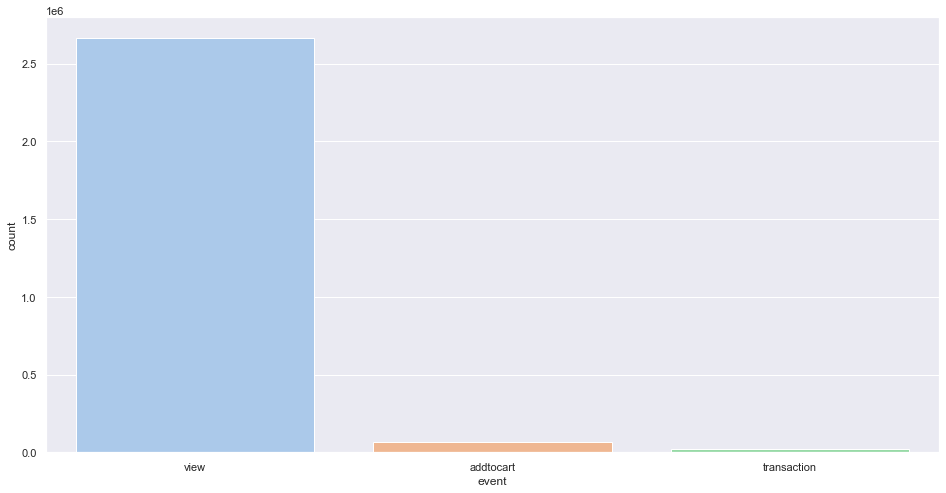

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(16, 8)) # Sample figsize in inches
sns.countplot(x='event',
              data=raw_events._to_pandas(),
              palette="pastel")

In [23]:
raw_events.groupby(['event']).event.count()

event
addtocart        69332
transaction      22457
view           2664312
Name: event, dtype: int64

The number of events of type `transaction` is minimal compared to the other types of events, `addtocart` and `view`.

Such indicator means that while considering only actual purchases, i.e., event type `transaction`, for a recommendations of products bought together, there is some good reasons to include the other type of events. However, mixing types of events changes the semantics of the recommendations (e.g., from "other customers bought X when buying Y" to "other customers added/viewed X when buying Y").

Another conclusion from this could be to also understand the reasons (or factors) that would lead a customer to purchase something. One potential way would be to analyze all events per customer up to a purchase of something because that would establish a link between the purchased `itemid` and all other `itemid` that the customers saw and/or added but never purchased.

In [24]:
raw_events._to_pandas().describe()

,timestamp,visitorid,event,itemid,transactionid,date
count,2756101,2756101,2756101,2756101,22457,2756101
unique,2750455,1407580,3,235061,17672,139
top,2015-06-17 19:13:47.120000,1150086,view,187946,7063,2015-07-26
freq,6,7757,2664312,3412,31,32703
first,2015-05-03 03:00:04.384000,NaN,NaN,NaN,NaN,NaN
last,2015-09-18 02:59:47.788000,NaN,NaN,NaN,NaN,NaN


While there are plenty of events, the number of customers, i.e., `visitorid`, seem to show that on average each customer carries out nearly 2 events in the period of the dataset.

Similarly, the number of actual purchases, i.e., `transactionid`, seem to be quite unique with barely 5000 repeating within the total of `transactionid`. 

#### Items

In [27]:
items = raw_events._to_pandas().itemid.value_counts()
for i in [2, 5, 10, 25, 50, 100, 1000]:
    print('Items that appear less than {:>4} times: {}%'.format(i, round((items < i).mean() * 100, 2)))

Items that appear less than    2 times: 31.31%
Items that appear less than    5 times: 61.31%
Items that appear less than   10 times: 76.55%
Items that appear less than   25 times: 89.6%
Items that appear less than   50 times: 95.25%
Items that appear less than  100 times: 98.2%
Items that appear less than 1000 times: 99.98%


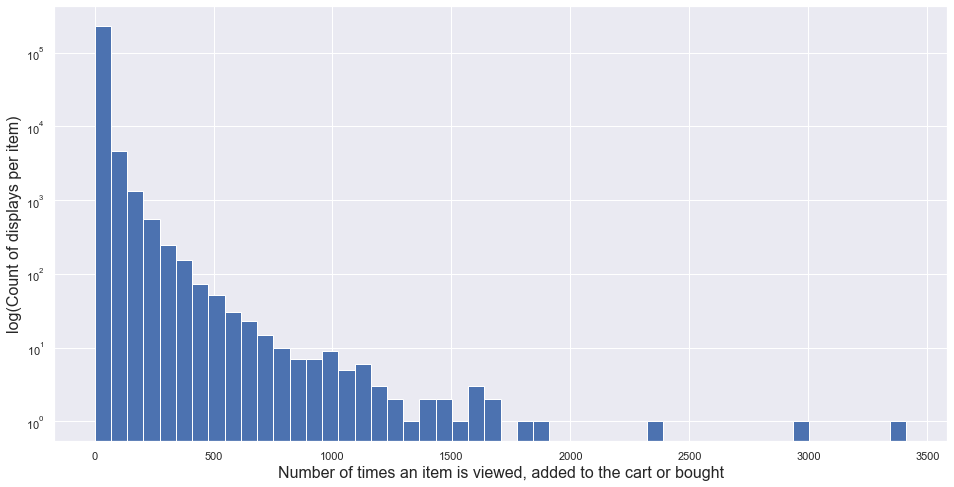

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(16, 8)) # Sample figsize in inches
plt.hist(items.values, bins=50, log=True)
plt.xlabel('Number of times an item is viewed, added to the cart or bought', fontsize=16)
plt.ylabel('log(Count of displays per item)', fontsize=16)
plt.show()

It is easy to see that most items, about 75%, are viewed, bought or added to the cart less than 5 times. With a big chunk of them, about 50%, only considered once or twice.

#### Visitors

In [29]:
visitors = raw_events._to_pandas().visitorid.value_counts()
for i in [2, 5, 10, 25, 50, 100, 1000]:
    print('Visitors that appear less than {:>4} times: {}%'.format(i, round((visitors < i).mean() * 100, 2)))

Visitors that appear less than    2 times: 71.15%
Visitors that appear less than    5 times: 94.2%
Visitors that appear less than   10 times: 98.35%
Visitors that appear less than   25 times: 99.69%
Visitors that appear less than   50 times: 99.91%
Visitors that appear less than  100 times: 99.97%
Visitors that appear less than 1000 times: 100.0%


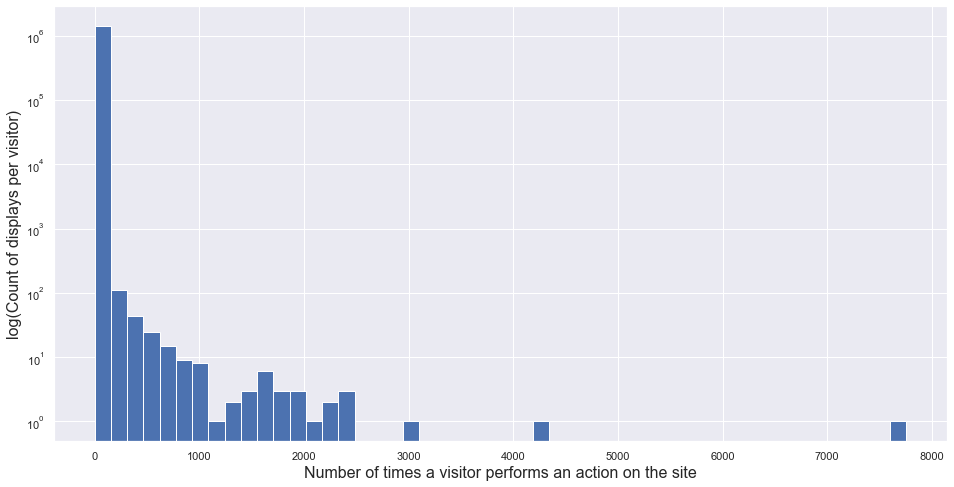

In [30]:
fig, ax = plt.subplots(ncols=1, figsize=(16, 8)) # Sample figsize in inches
plt.hist(visitors.values, bins=50, log=True)
plt.xlabel('Number of times a visitor performs an action on the site', fontsize=16)
plt.ylabel('log(Count of displays per visitor)', fontsize=16)
plt.show()

Similarly, a notable majority of the visitors perform one action, i.e., `event`, in the e-commerce site once, about 71%, and almost everyone does it less than 10 times, about 98%.

This information leads to potentially consider how many times a customer views items compared to adding them to the cart and buying. For example, as a counter of the amount of actions a customer will do to buy something or not (and focusing perhaps on the why the customer did not buy something).

#### Date/time

In [31]:
# timestamp is in UTC. It is not clear from the description of the dataset the exact timezone.
# We try as it is, i.e., UTC, and we will see if we shift or not after plotting
raw_events['hour'] = raw_events.timestamp.apply(lambda x: timestamp_to_hour(x.to_pydatetime(), timezone='US/Eastern'))

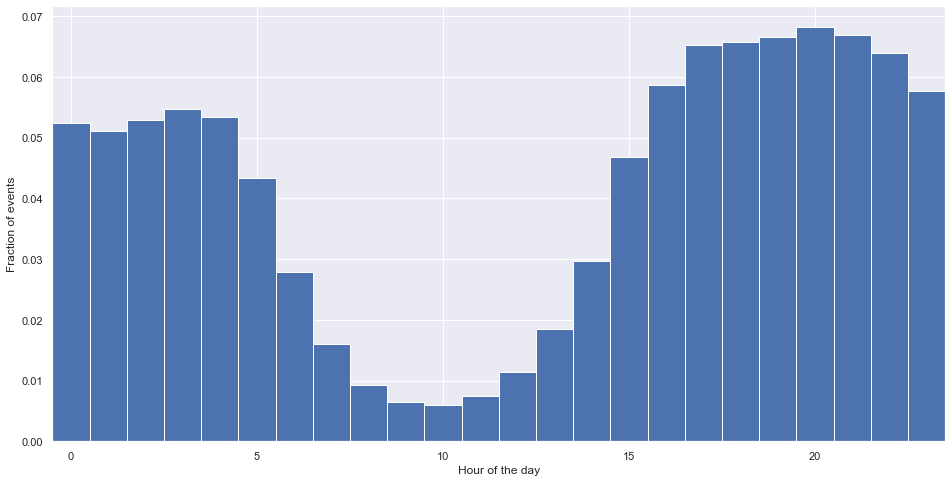

In [32]:
fig, ax = plt.subplots(ncols=1, figsize=(16, 8)) # Sample figsize in inches
raw_events.hour.hist(bins=np.linspace(-0.5, 23.5, 25), alpha=1, density=True)
plt.xlim(-0.5, 23.5)
plt.xlabel("Hour of the day")
plt.ylabel("Fraction of events")
plt.show()

#### Properties

In [33]:
properties_categoryid = raw_items_properties[(raw_items_properties.property == 'categoryid')].drop_duplicates('itemid', keep='first')
# properties_available = raw_items_properties[(raw_items_properties.property == 'available')]
categories = properties_categoryid.value.value_counts()
for i in [2, 5, 10, 25, 50, 100, 500, 1000, 5000]:
    print('ategories that appear less than {:>4} times: {}%'.format(i, round((categories < i).mean() * 100, 2)))    

ategories that appear less than    2 times: 7.1%
ategories that appear less than    5 times: 14.61%
ategories that appear less than   10 times: 21.8%
ategories that appear less than   25 times: 32.57%
ategories that appear less than   50 times: 42.61%
ategories that appear less than  100 times: 56.0%
ategories that appear less than  500 times: 84.57%
ategories that appear less than 1000 times: 91.84%
ategories that appear less than 5000 times: 99.35%


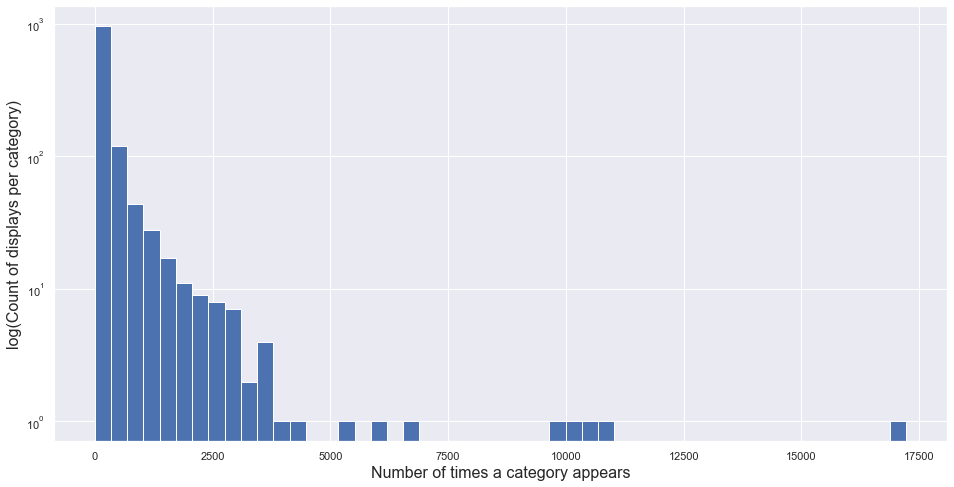

In [34]:
fig, ax = plt.subplots(ncols=1, figsize=(16, 8)) # Sample figsize in inches
plt.hist(categories.values, bins=50, log=True)
plt.xlabel('Number of times a category appears', fontsize=16)
plt.ylabel('log(Count of displays per category)', fontsize=16)
plt.show()

### A naive recommender

A naive recommender for an item X could be one that suggests a subset of all the items that other customers have bought together with item X.

Such recommender doesn't take into account much more than the chances of items being bought together in the realm of a customer within a considered period.<br>
On the bright side, the recommender is independent of the customer's behaviour (i.e., the suggestions are independent from the number of purchases) because it relies solely on the item-to-item "relationships".

In [35]:
# Naive recommender
# Suggest n random items of a set of all other items bought together with the queried one by all users
# Supports other actions like adding to the cart or viewing an item
def items_to_item(events,
                  itemid,
                  actions='transaction'):
    # Customers who bought some specific itemid: event == 'transaction' && transactionid != NaN
    # Otherwise (event == 'view' || event == 'addtocart') && transactionid == NaN)
    
    def visitors_to_item(events, itemid, actions):
        filtered_events_per_itemid = events[(events.itemid == itemid)]

        if type(actions) is not list:
            actions = [actions]
            
        # Create empty pd.DataFrame WITH structure
        #visitors = filtered_events_per_itemid.iloc[0:0,:].copy()
        visitors = {}
        
        for a in actions:
            if a == 'transaction':
                filtered_events_per_event = filtered_events_per_itemid[(filtered_events_per_itemid.event == a) &
                                                                       (filtered_events_per_itemid.transactionid.notna())]
            else:
                filtered_events_per_event = filtered_events_per_itemid[(filtered_events_per_itemid.event == a) &
                                                                       (filtered_events_per_itemid.transactionid.isna())]

            visitors[a] = list(filtered_events_per_event.visitorid.unique())

        return visitors
    
    visitors_list_per_event = visitors_to_item(events, itemid, actions)

    items_lists = []
    for action, visitors_list in visitors_list_per_event.items():
        filtered_events_by_action = events[(events.event == action)]
        if action == 'transaction':
            filtered_events_by_action = filtered_events_by_action[(filtered_events_by_action.transactionid.notna())]
        else:
            filtered_events_by_action = filtered_events_by_action[(filtered_events_by_action.transactionid.isna())]
            
        items_lists_per_transaction = [list(filtered_events_by_action[(filtered_events_by_action.visitorid == visitorid)].itemid.unique()) for visitorid in visitors_list]
        items_lists += items_lists_per_transaction
    
    items = set().union(*items_lists)
    return list(items)

In [36]:
itemid = '200793'
actions=['transaction', 'addtocart']
filtered_events = raw_events[(raw_events.date < str_to_date('2015-09-01'))]

recommendations = items_to_item(filtered_events, itemid, actions)
recommendations

['380775',
 '15335',
 '400969',
 '105792',
 '80582',
 '302422',
 '237753',
 '12836',
 '200793',
 '25353',
 '317178']

### A collaborative filtering recommender

The solution that follows is based in matrix factorization.
In an effort to consider all type of events, I have converted the `transaction` to a number and aggregated all transactions per `visitorid` within the considered period accounting for the weight of each type of `transaction` in the dateset for fairness.

References: https://www.benfrederickson.com/matrix-factorization/ and improvements, https://www.benfrederickson.com/fast-implicit-matrix-factorization/

In [37]:
# Filtering the events by date as stated (presumably due to training/validation/test dataset splits).
# Note that such filtering is not adequate for matrix factorization approaches because there is not 
# really a training split in such approaches as they are trying to fill in the 'missing spots'
filtered_events_by_date = raw_events[(raw_events.date < str_to_date('2015-09-01'))]

In [38]:
# We could filter the events by type and choose those of type 'transaction' (i.e., actual purchases)
# However, by doing this we ignore those visitors that do simply view and/or add items to the cart.
# This implies a problem of cold start for those customers who have never bought anything, but this
# is up to the semantics of the recommendations as well.
# E.g., "Others customers bought these other items" vs. "Others customers added these items to their cart"
filtered_events_by_action = filtered_events_by_date[(raw_events.event == 'transaction')]
filtered_events = filtered_events_by_action[['visitorid', 'itemid', 'transactionid']]
# And we simply convert the purchases to some kind of binary event
filtered_events.transactionid = filtered_events.transactionid.apply(lambda x: 1 if x else 0)

In [39]:
# Adding 'view' and 'addtocart' events in the events to recommend on based on a normalised weight
# over all the events in the dataset (see https://www.kaggle.com/aafrin/retail-rocket-recommender-system-for-beginners)
def get_normalised_group(group, statistics):
    
    def get_weight(x, statistics):
        statistics_normalised = dict(statistics)
        
        total = sum(list(statistics_normalised.values()))

        for k, v in statistics_normalised.items():
            statistics_normalised[k] = statistics[k]/total
            
        return statistics_normalised[x]
    
    group_events = list(group.event)
    
    rating = 0
    for e in group_events:
        rating += get_weight(e, statistics)

    return rating

filtered_events_statistics = dict(filtered_events_by_date['event'].value_counts())
# filtered_events = filtered_events_by_date.drop_duplicates(['visitorid', 'itemid', 'date']).groupby(['visitorid','itemid']).apply(get_normalised_group, statistics=filtered_events_statistics).reset_index()
filtered_events = filtered_events_by_date.drop_duplicates(['visitorid', 'itemid', 'date'])
filtered_events = filtered_events[['visitorid', 'itemid', 'event']]
filtered_events = filtered_events.groupby(['visitorid','itemid']).apply(get_normalised_group, statistics=filtered_events_statistics).reset_index()

In [40]:
filtered_events.columns = [*filtered_events.columns[:-1], 'transactionid']
filtered_events.head()

,visitorid,itemid,transactionid
0,1,72028,0.966670
1,10,248766,0.966670
2,1000,248975,0.966670
3,10000,359491,0.966670
4,10000,401285,1.933339


In [41]:
filtered_events.describe()

,transactionid
count,1.905695e+06
mean,1.009373e+00
std,5.157814e-01
min,8.191190e-03
25%,9.666697e-01
50%,9.666697e-01
75%,9.666697e-01
max,1.140670e+02


In [42]:
users_index_map, index_users_map = remap_list(list(filtered_events.visitorid.unique()))
items_index_map, index_items_map = remap_list(list(filtered_events.itemid.unique()))

In [43]:
def create_ratings_matrix(events,
                          user_col='visitorid',
                          item_col='itemid',
                          rating_col='transactionid',
                          user_index=None,
                          item_index=None,
                          mode='coo'):

    num_users = events[user_col].nunique()
    num_items = events[item_col].nunique()
    
    if user_index:
        users_index_map = user_index
    else:
        users_index_map, index_users_map = remap_list(list(events[user_col].unique()))
        
    if item_index:
        items_index_map = item_index
    else:
        items_index_map, index_items_map = remap_list(list(events[item_col].unique()))
    
    
    if mode == 'dok':
        ratings = sparse.dok_matrix((num_users, num_items), dtype=events[rating_col].dtype)
        
        for row in events.itertuples(index=False):
            i = users_index_map[row[user_col]]
            j = items_index_map[row[item_col]]
            v = row[raing_col]
    
            ratings[i, j] = v
    elif mode == 'coo':
        i = events[user_col].apply(lambda x: users_index_map[x])
        j = events[item_col].apply(lambda x: items_index_map[x])
        data = events[rating_col].values

        ratings = sparse.coo_matrix((data, (i, j)), shape=(num_users, num_items))
    else:
        raise("Nope")

    return ratings, users_index_map, items_index_map

In [44]:
user_to_item_matrix, _, _ = create_ratings_matrix(filtered_events,
                                                  user_index=users_index_map, 
                                                  item_index=items_index_map)
user_to_item_matrix.shape

(1250856, 222982)

In [45]:
# Initialize the model(s)
cf_als = implicit.als.AlternatingLeastSquares(factors=128,
                                              regularization=1.5,
                                              iterations=15,
                                              calculate_training_loss=True)

cf_approximate_als = implicit.approximate_als.NMSLibAlternatingLeastSquares(factors=128,
                                                                            regularization=1.5,
                                                                            iterations=15,
                                                                            calculate_training_loss=True)

cf_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=128,
                                                  learning_rate=1.5,
                                                  regularization=1,
                                                  iterations=75,
                                                  verify_negative_samples=True)

cf_lmf = implicit.lmf.LogisticMatrixFactorization(factors=128,
                                                  learning_rate=0.1,
                                                  regularization=1.5,
                                                  iterations=5)



In [46]:
# Train the model(s) on the transposed sparse matrix of user/item/[confidence|rating weights]
item_to_user_matrix = user_to_item_matrix.T.tocsr()

cf_als.fit(item_to_user_matrix, show_progress=True)
# cf_bpr.fit(item_to_user_matrix, show_progress=True)
# cf_lmf.fit(item_to_user_matrix, show_progress=True)

# cf_approximate_als.fit(item_to_user_matrix, show_progress=True)

In [47]:
# Recommend items for one user (note that both the user and the results correspond to the internal indexes)
user_index=0
n=100
recommendations = cf_als.recommend(userid=user_index,
                                   user_items=user_to_item_matrix.tocsr(),
                                   N=n,
                                   filter_already_liked_items=True,
                                   recalculate_user=True)
recommendations[:10]

[(1407, 0.0005404296807055052),
 (351, 0.00031965440230175403),
 (12847, 0.00023763780022188928),
 (763, 0.00022060799617162468),
 (11857, 0.00018129208982128862),
 (657, 0.00014632314594394856),
 (901, 0.0001268716738396152),
 (10370, 0.00010526420976675356),
 (2483, 0.00010249147169301209),
 (6192, 0.00010033765800385133)]

## Some functions for a potential API

In [48]:
def get_single_user_implicit_recommendations(user_to_recommend,
                                             trained_model,
                                             users_items_matrix,
                                             users_index_map,
                                             index_items_map,
                                             user_col='visitorid',
                                             n=100):

    user_recommendations = list()
        
    if user_to_recommend in users_index_map.keys():
        user_index = users_index_map[user_to_recommend]
        user_item_index_recommendations = model.recommend(userid=user_index,
                                                              user_items=users_items_matrix.tocsr(),
                                                              N=n,
                                                              filter_already_liked_items=True,
                                                              recalculate_user=True)
        user_item_index_recommendations_sorted = sorted(user_item_index_recommendations,
                                                            key=lambda x: x[1],
                                                            reverse=True)
        user_recommendations = list(map(lambda item_index: index_items_map[item_index],
                                        [t[0] for t in user_item_index_recommendations_sorted]))
        
    return user_recommendations

def get_implicit_recommendations(users_to_recommend,
                                 trained_model,
                                 users_items_matrix,
                                 users_index_map,
                                 index_items_map,
                                 user_col='visitorid',
                                 n=100):


    
    num_users_prediction = users_to_recommend[user_col].size
    recommendations = {}
    
    start = time.time()
    with tqdm.tqdm(total=num_users_prediction) as progress:
        for user in list(users_to_recommend[user_col]):
            recommendations[user] = get_single_user_implicit_recommendations(user,
                                                                             trained_model,
                                                                             users_items_matrix,
                                                                             users_index_map,
                                                                             index_items_map,
                                                                             user_col,
                                                                             n)
    
            progress.update(1)

    return recommendations

In [49]:
# Configuration parameters...
N = 100
model = cf_als
pred_users = raw_prediction_users.head(5)
pred_users

,visitorid
0,593408
1,71998
2,1403739
3,693797
4,1244757


In [50]:
recommendations = get_implicit_recommendations(pred_users,
                                               model,
                                               user_to_item_matrix,
                                               users_index_map,
                                               index_items_map,
                                               n=N)
recommendations
# save_recommendations(recommendations, "data/pong.csv")

100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


{'593408': [],
 '71998': ['320130',
  '438484',
  '389158',
  '122604',
  '80435',
  '227318',
  '340375',
  '463617',
  '51650',
  '218746',
  '14671',
  '337327',
  '237952',
  '455183',
  '179834',
  '108486',
  '82586',
  '49621',
  '340825',
  '395435',
  '76196',
  '90240',
  '73602',
  '109583',
  '446820',
  '9211',
  '227211',
  '137352',
  '396042',
  '33912',
  '248614',
  '46130',
  '53151',
  '334520',
  '448453',
  '262982',
  '149275',
  '194270',
  '26228',
  '33907',
  '179601',
  '446411',
  '408203',
  '103156',
  '296619',
  '98547',
  '88904',
  '56303',
  '357054',
  '243606',
  '344071',
  '124272',
  '460188',
  '383828',
  '117206',
  '393111',
  '429094',
  '374092',
  '357583',
  '439956',
  '293139',
  '231243',
  '414460',
  '184199',
  '173313',
  '17478',
  '392074',
  '461091',
  '57788',
  '416399',
  '39561',
  '394052',
  '449571',
  '384157',
  '425951',
  '386112',
  '369565',
  '271896',
  '134118',
  '363111',
  '462188',
  '304537',
  '403',
  '1

In [ ]:
l = lambda user: get_single_user_implicit_recommendations(user,
                                                       model,
                                                       user_to_item_matrix,
                                                       users_index_map,
                                                       index_items_map,
                                                       n=N)
pred_users['recommendations'] = pred_users.visitorid.apply(l, axis=1)
pred_users.head()